In [0]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns

In [7]:
from google.colab import files
uploaded=files.upload()

Saving test_tweets_anuFYb8.csv to test_tweets_anuFYb8.csv


In [0]:
import io
test_df=pd.read_csv(io.BytesIO(uploaded['test_tweets_anuFYb8.csv']))

In [10]:
uploaded=files.upload()

Saving train_E6oV3lV.csv to train_E6oV3lV.csv


In [0]:
train_df=pd.read_csv(io.BytesIO(uploaded['train_E6oV3lV.csv']))

In [13]:
# Inspecting the dataset
train_df.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [0]:
complete=train_df.append(test_df,ignore_index=True)

## Cleaning The Text

In [0]:
import re
def remove_pattern(input_txt,pattern):
     r=re.findall(pattern, input_txt) #finds all occurrences
     
     for i in r:
      input_txt=re.sub(i,'',input_txt) # replaces substrings
      
     return input_txt 

In [0]:
# remove twitter handles @user
complete['Tweet']=np.vectorize(remove_pattern)(complete['tweet'],'@[\w]*')

In [0]:
# remove punctuations, special characters, numbers
import string
complete['Tweet']= complete['Tweet'].str.replace("[^a-zA-Z#]"," ")

In [0]:
# removing short words
complete['Tweet']=complete['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [19]:
# Splitting strings into tokens
tweet_final=complete['Tweet'].apply(lambda x: x.split())
tweet_final.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: Tweet, dtype: object

In [20]:
# Stemming
# Stemming is a process of removing
# useless suffixes and prefixes from words
from nltk.stem.porter import *
stemmer= PorterStemmer()

tweet_final=tweet_final.apply(lambda x: [stemmer.stem(i) for i in x])
tweet_final.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: Tweet, dtype: object

In [0]:
for i in range(len(tweet_final)):
  tweet_final[i]=' '.join(tweet_final[i])
 
complete['Tweet']=tweet_final

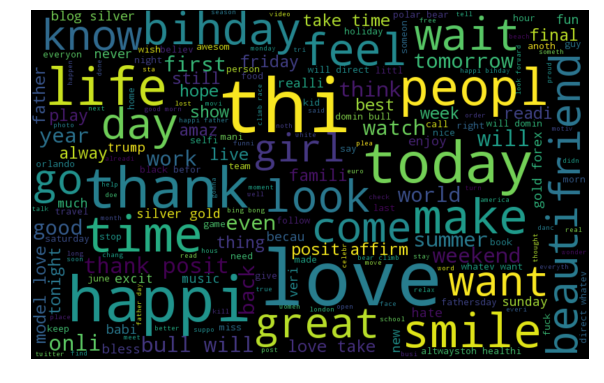

In [22]:
# using WordCloud to plot
import matplotlib.pyplot as plt
words=' '.join([text for text in complete['Tweet']])

from wordcloud import WordCloud
wordcloud= WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


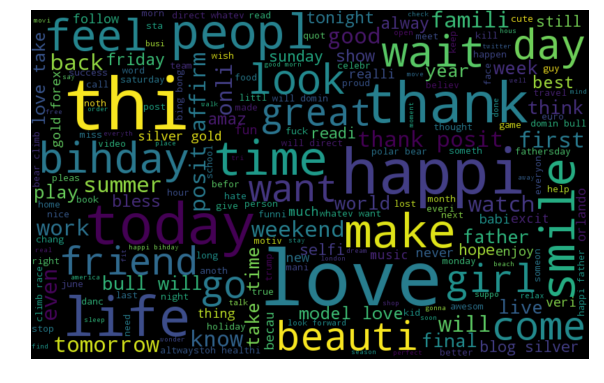

In [23]:
positive= ' '.join([text for text in complete['Tweet'][complete['label']==0]])
wordcloud= WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

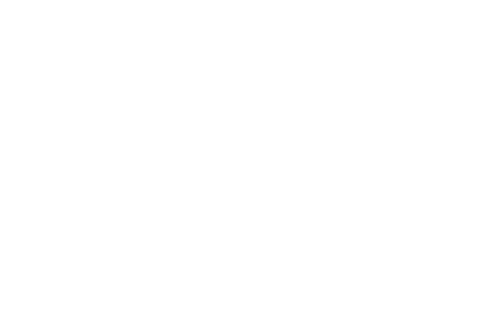

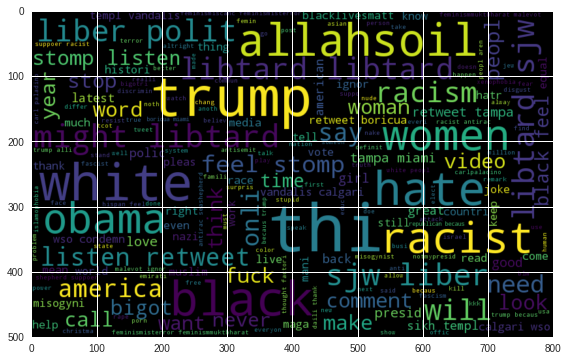

In [25]:
negative= ' '.join([text for text in complete['Tweet'][complete['label']==1]])
wordcloud= WordCloud(width=800,height=500,random_state=21,max_font_size=100).generate(negative)
plt.axis('off')
plt.figure(figsize=(11,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()

In [0]:
# Since Hashtags tell us a lot about the type of tweet
# We will extract all hashtags and separate them into positives and negatives

def hashtag_extract(x):
     hashtags=[]
     for i in x:
        ht=re.findall(r"#('\w+')",i)
        hashtags.append(ht)
        
     return hashtags

In [0]:
ht_positive= hashtag_extract(complete['Tweet'][complete['label']==0])
ht_negative= hashtag_extract(complete['Tweet'][complete['label']==1])

ht_positive=sum(ht_positive,[])
ht_negative=sum(ht_negative,[])

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer= TfidfVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')
tfidf= tfidf_vectorizer.fit_transform(complete['Tweet'])

## Building Model Using Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train=tfidf[:31962,:]
test=tfidf[31962:,:]

x_train,x_val,y_train,y_val=train_test_split(train,train_df['label'],test_size=0.33,random_state=42)
model=LogisticRegression()
model.fit(x_train,y_train)

prediction=model.predict_proba(x_val)
prediction_int=prediction[:,1]>=0.3
prediction_int=prediction_int.astype(np.int)

f1_score(y_val,prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5419039869812856

In [0]:
prediction=model.predict_proba(test)
prediction_int=prediction[:,1]>=0.3
prediction_int=prediction_int.astype(np.int)

test_df['label']=prediction_int
submission=test_df[['id','label']]
submission.to_csv('sub_lreg_tfidf.csv', index=False)
files.download('sub_lreg_tfidf.csv')